In [1]:
# Import 3rd-party frameworks.

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import time as tm
import json
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import gc

In [2]:
from Mike_NB_01 import *

In [4]:
file_id = "06_all_to_Mar18" #"03_all"
table = np.load("/mnt/data/Trading/table_" + file_id + ".npy")
print("table: {}".format(table.shape))
table_markets = []
reports = None
with open("/mnt/data/Trading/reports_" + file_id + ".json", "r") as f:
    reports = json.loads(f.read())
# print(reports)
markets = [ report[0: report.find(':')] for report in reports ]
# print(markets)

table: (321, 2740320, 12)


**Non-tablular Machine Learning, training on a non-tabular trainig data set.**

- The placeholder candles for non-existing candles account for the sheer 57% of the total area. Placeholders exist because candles don't exist until the market is listed
- Even after listing, about 1%, or so, of candles are missing, due to exchanges fault etc., although they are invisible in the plot. Missing candles are another type of placehoders.
- So, a market has a distribution of placeholder (i.e., non-existing or missing) candles, of which we don't know the price/volume
    - Price could be borrowed from other sources, as we know there is little difference in price.
    - But volumes can not be borrowed, as exchanges have different scale, as well as different quality.
- **EUREKA**: we found a training algorithm that can digest the distribution of placeholder candles.
    - without it, if a single market has a placeholder candle at a timepoint, we will have no way but lose all other markets' candle at that time point, because neural networks require synchronized tabular input data.
    - then, we will lose almost all candles (information), because at almost all time points, there exists a market that has a placeholder candle at one of the points. (See the plot.)
    - The algorithm has to be coded and tested yet. If successful, We will be able to make use of 100% of the candles.
- **We have defeated lots of competitors**:
    - by collecting and **perfecting** extensive historical candle data
    - by making use of 100% of the extensive candle data, no matter how placeholder (non-existing or missing) candles are distributed.
    - The models trained on 100% of the extensive candle data, which is of much more amount than lots of competitors, will have learned superior knowledge of the crypt markets. It will work superior in predicting staking pools.

We should be able to get average price from a candel.
- The rate of Base Volume and Quote Volume is the average price during the candle.
- The same to TakerBuyBaseVolume and TakerBuyQuoteVolume.
- Open/High/Low/Close prices cannot give precise average price.
- Average price will be more suitable than any of the OHLC prices, in Mozaic project.

Calume:

My only concern is if it takes into consideration levels of prices. Will the AI be able to differentiate when a level is broken or not? As using an average for everything will miss these areas of most importance.
eg key level breakout for 1 month is $7000k. If level is broken at 3:00:02 and then it wicks up above the line til 3:00:20 then dumps below and continues to dump for the remainder of the minute. This will miss it ever passing the level if we used average price and there was a wider price below the level.
May not be important for the way the AI decides but its what all traders look at

Mike:
- Yeah, I understand this microscopic, analytic detailed approach.  Our perspective is more of telescopic, compared to this.
- We want to predict the future 60 one-minute candles' average behavior from the past thousands/millions one-minute candles data.
- From the next 60 one-minute candles, the earlier candles are more important and will have higher weight,
- because if our portfolio will be staying during the next 60 candles, the earlier candles' result will exist longer with our staked assets, accruing more rewards.
- So, the minimum number of candles we will be handling at one time is 60, not 1.
    - Any type of very specific inter-candle price, or other feature, accumulated across 60 candles, will give the same effect as the average intra-candle prices accumulated across 60 candles.
    - ML will harvest from the scale, i.e. the huge number of candles, or big data, statistically. The bigness will provide preciseness.
    - ML will not seek to benefit from analytic, microscopic approach.

Thanks boss for the diversifying points.
- Binance candles have:
    - opening/closing time
    - open/high/low/close prices
    - base volume
    - quote volume
    - taker buy base volume
    - taker buy quote volume
- We want to remove redundant information
- From our ML-like, statistical perspective, we are interested in
    - closing time  (a bit recent info than opening time)
    - average price during the candle, (if we can get it)
    - base volume
    - quote volume, (it can be deduced from base volume and average price, like quote volume = base volume * average price, but neural networks are not flexible enough to find quote volume from base volume and average price and so we sometimes allow redundant info if the info is important)
    - taker buy base volume, (this is less important, but it shows who of taker and maker was eager to initiate transactions during the candle).
    - taker buy quote volume, (the same arguement with quote volume. It's an allowed redundant info.)
- If we need to squeeze the info once more, then the followings will survive:
    - rank 3. closing time
    - rank 1. average price
    - rank 2. base volume, (why? why not quote? becasue all -/usdt markets share the same base asset, and the numerals will have the same dimension and the arithmetic taking place in neural networks will have intuitive meanings.)
    - rank 4. taker buy base volume, (the same argument as with base volume

In [14]:
print(datetime.fromtimestamp(table[0,0,0]/1000), datetime.fromtimestamp(table[0,-1,0]/1000))

TypeError: only size-1 arrays can be converted to Python scalars

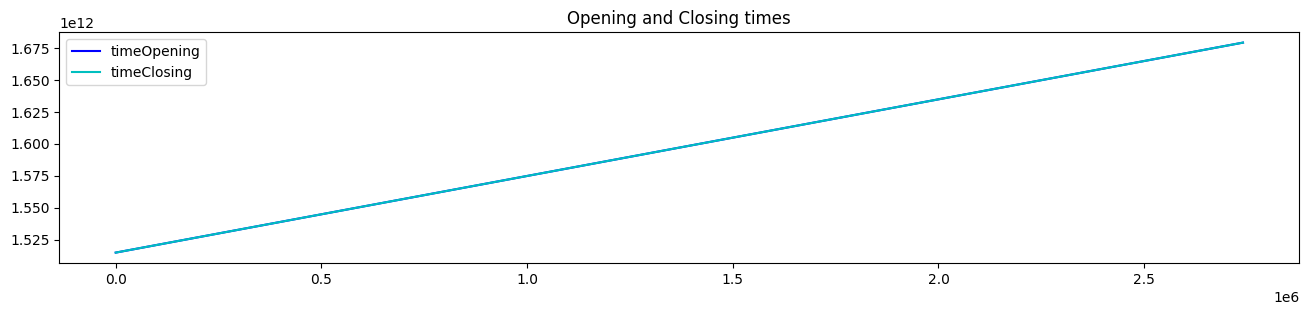

min increment of closing times across candles of market 0: 60000.0, max: 60000.0
min of <closing time -opening time> across candles of market 0: 0.0, max: 59000.0
2018-01-01 00:00:00 2023-03-18 23:59:00


In [5]:
tO = table[0, :, 0] # opening time
tC = table[0, :, 6] # closing time
series = [ (tO, "timeOpening", 'b'), (tC, "timeClosing", "c") ]
ShowSingle("Opening and Closing times", series)
tInc = table[0, 1:, 0] - table[0, :-1, 0]
print("min increment of closing times across candles of market 0: {}, max: {}".format(np.min(tInc), np.max(tInc)))
tDelta = tC - tO
print("min of <closing time -opening time> across candles of market 0: {}, max: {}".format(np.min(tDelta), np.max(tDelta)))
print(datetime.fromtimestamp(table[0, 0, 0]/1000), datetime.fromtimestamp(table[0, -1, 0]/1000))

- OK: The opening time and closing time are a linear function, meeting our expectation. (See the plot.)
- OK: We made sure that opening time strictly increase by one minute at a time, in the Bot code. (min = max = 60000 miliseconds)
- NO: We assumed closing time is one second earlier than the next opening time, or 59 seconds after the currunt opening time. BUT this assumption was not checked in the Bot. Now we suspect this assumption holds.
    - min (closing - opening) = 59000, and max(closing - opening) = 59000 were expected,
    - but the reality is min = 0, max = 59000
- Let's look into them

In [6]:
argmin = np.argmin(tDelta)
nWidth = 5
interval = range(max(0, argmin - nWidth), min(argmin + nWidth, tDelta.shape[0]))
print(tDelta[interval])
print(table[0, interval, 11])

[59000. 59000. 59000. 59000. 59000.     0.     0.     0.     0.     0.]
[-1. -1. -1. -1. -1.  0.  0.  0.  0.  0.]


- OK: table[:, :, 11] has two kinds of values: 0.0 and -1.0.
    - 0.0 means the candle was recorded by Binance, while -1.0 means the candle was created by the Bot becasue it was missing. (created by time-interpolating between latest past and earliest future candles.)
- Conclusion: **Our assumption was wrong and Binance made closing time be the same as opening time.**
- Conclusion: **Get rid of closing time, for all candles of all markets.**

In [7]:
tInc = table[:, 1:, 0] - table[:, :-1, 0]
print(np.min(tInc), np.max(tInc))
print(np.min(table[:, 0, 0]), np.max(table[:, 0, 0]))

60000.0 60000.0
1514764800000.0 1514764800000.0


- OK: Opening time increases by exactly 60,000 miliseconds across all candles across all 321 markets.
- OK: The opening time of the first candle of all markets, begin at the same time.

In [8]:
del tO, tC, tDelta, tInc
gc.collect()

3540

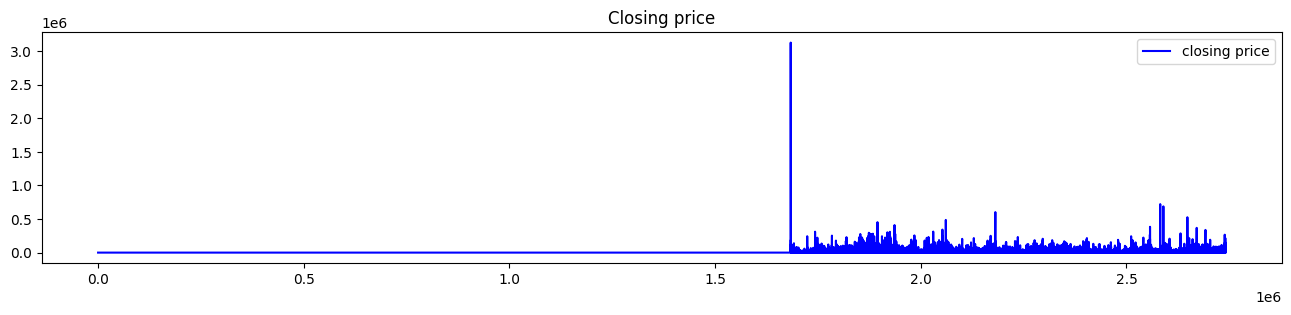

[      0.         0.         0.   3127786.19  984603.98  623740.27]


In [9]:
pC = table[0, :, 5]
series = [(pC, "closing price", "b")]
ShowSingle("Closing price", series)

argmin = np.argmax(pC)
nWidth = 3
interval = range(max(0, argmin - nWidth), min(argmin + nWidth, pC.shape[0]))
print(pC[interval])

- The peak price is over 30X larger than nearby prices (3127786.19 vs. 984603.98) , for the market 0.
- It shows that the very first minute saw very high price.

In [10]:
bias = 100; times = 30
nPeaks = np.sum(np.ones( (table.shape[1]-1))[ np.where( np.logical_and( 100.0 < table[0,:-1,5], times * table[0,:-1,5] < table[0,1:, 5] )) ]).astype(int)
print("{} candles have prices that are over {} and over {}x less than the next candle's price.".format(nPeaks, bias, times))

4031 candles have prices that are over 100 and over 30x less than the next candle's price.


- Price fluctuation happens not only during launch minutes.
- So, should we remove the first minutes (or days or weeks) worth of candles, for a token?
- Won't it be distortion of reality if we remove the first price fluctuation?
- On the other hand, will our ML models can learn/accommodate the initial storms of price?
- Conclusion: **Give it a try that we keep all the reality data in the training data set.**

(1684544,) (321, 2740320, 12)


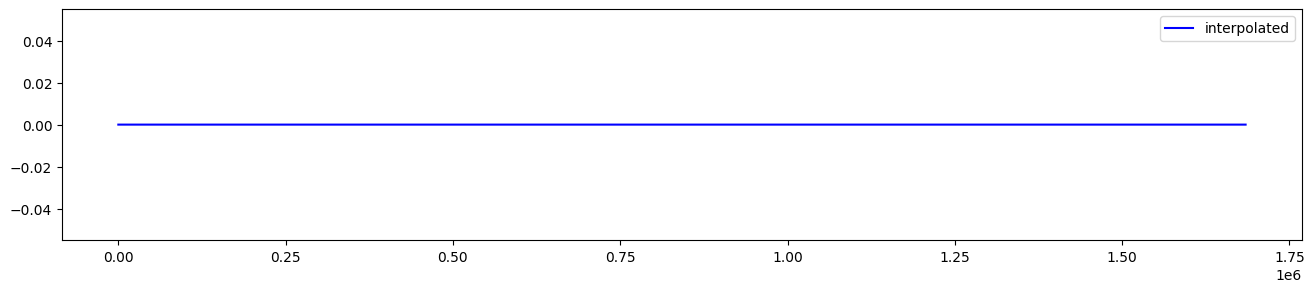

In [11]:
interpolated = table[0, :, 5][table[0, :, 11] < 0]
print(interpolated.shape, table.shape)
ShowSingle("", [(interpolated, "interpolated", "b")])

- NO: All OHLC prices are not interpolated but set to zero, by mistake, in the BOT code.

- Let's exclude interpolated prices and volumes from training (both from X and Y). They are just a placeholder in a matrix data set.
- Then we will have to include timestamp (closing time) to the training data set, because the interpolated candles are scattered irregularly across time.
- timestamps, which is an indefinitely/infinitely increasing sequence, can make negative effects on neural networks.
- Instead, we will convert timestamps to hour, day of week, week, and year, which all cyclically develop in a finite range , except for year.
- This way, we will give the models chances to learn hidden, mixed cyclic changes of price/volume.
- Further, we will give the models chances to learn the shift of cycles over time.
- We have already made sure that closing times are one-incremental.

In [12]:
print("table shape (nMarkets, nCandles, nAttributes): {}".format(table.shape))

table shape (nMarkets, nCandles, nAttributes): (321, 2740320, 12)


/home/mike/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


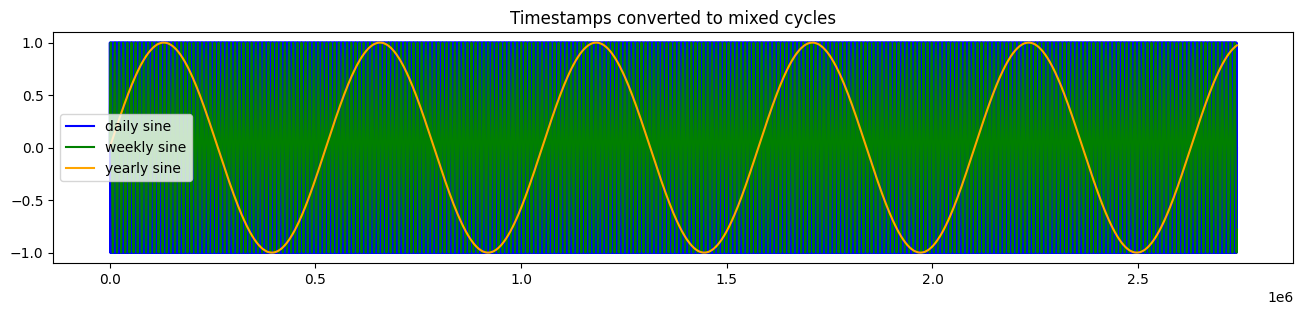

In [13]:
ts = table[0, :, 0]     # closing time, in milisecond, of all candles of market 0. Shared among all markets.append
ts = ts/60000           # The unit of timestamp: 1 minute.
ts = ts - ts[0]         # ts starts with 0.

daily_sine = np.sin(2*np.pi*ts/(60*24))     # The sine function that cycles every 24 hour, representing time moment of day.
weekly_sine = np.sin(2*np.pi*ts/(60*24*7))     # The sine function that cycles every 7 days, representing time moment of week.
yearly_sine = np.sin(2*np.pi*ts/(60*24*365))     # The sine function that cycles every 365 days, representing time moment of yeah.

series = [ (daily_sine, "daily sine", "b"), (weekly_sine, "weekly sine", "g"), (yearly_sine, "yearly sine", "orange")]
ShowSingle("Timestamps converted to mixed cycles", series)

- 1902 days worth of sines are shown.
- The yearly sine is clear; the monthly sign is hardly recognized; daily sine is burred completely.

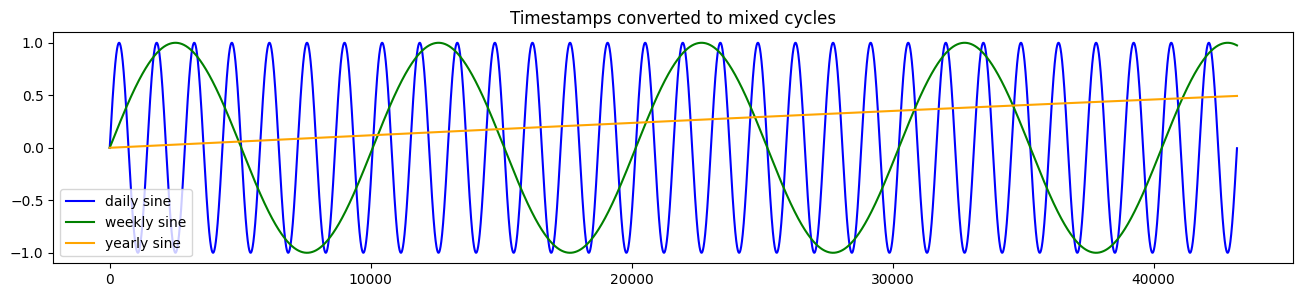

In [13]:
interval = range(1440*30)
series = [ (daily_sine[interval], "daily sine", "b"), (weekly_sine[interval], "weekly sine", "g"), (yearly_sine[interval], "yearly sine", "orange")]
ShowSingle("Timestamps converted to mixed cycles", series)

- 30 days worth of sines are shown.
- These sines are expexted to **make resonance with daily, weekly, or yearly cyclic behavors of price/volume,** learning those behavors, when fed to neural networks togethr with price/volume data.
- We know 
    - the phases of these sines are different.
    - the phases might be shifted, by events or by whatever.
- So, we need to let models learn the different phases and their shift.

- sin( w * ts + shift ) = sin( w * ts ) * cos( shift ) + cos( w * ts ) * sin( shift )
- in orther words, shifted sine = daily_sine * cos( shift ) + daily_cosine * sin( shift )
- daily_sine and daily cosine come from time stamp.
- cos( shift ) and/or sin( shift ), or simply shift, will be learned by neural networks.
- I hope this will be implemented in tensorflow, and help **model dynamically shifting mixed cyclic behavors.**

In [ ]:
# Details


In [14]:
nLatest = 0

Time = table[0, -nLatest:, 0].astype(np.int32)      # int32 will not be enough in 2037.
Price = table[:, -nLatest:, 4].astype(np.float32)
Volume = table[:, -nLatest:, 5].astype(np.float32)

# BaseVolume = table[:, -nLatest:, 5].astype(np.float32)
# QuoteVolume = table[:, -nLatest:, 7].astype(np.float32)
# TB_QuoteVolume = table[:, -nLatest:, 9].astype(np.float32)
# TB_QuoteVolume = table[:, -nLatest:, 10].astype(np.float32)

# del table   # save memory
gc.collect()

13120

In [15]:
print(Time.shape[0])
index = range(0, Time.shape[0], 1440)
time = Time[index]
price = Price[:, index]
volume = Volume[:, index]
print(volume.shape)

2738881
(54, 1903)


In [16]:
for market in range(price.shape[0]):
    price[market, :][price[market, :] > 0] = 1
argmax = np.argmax(price[:, :] > 0, axis=1)
# print(argmax)
marketOrder = np.argsort(argmax)
print(marketOrder)

# table = table[marketOrder]

price = price[marketOrder]
volume = volume[marketOrder]
markets = [ markets[i] for i in marketOrder]
print(markets)

# argmax = np.argmax(price[:, :] > 0, axis=1)
# print(argmax)
for market in range(price.shape[0]):
    price[market, :][price[market, :] > 0] = market


[11  3  4 46  7  6 34 20 13 18 27 15 17 40  5 16 35 29  8 47  9 38 25 32
 21 36 10 44 53  1 37 19 14 26 22 39 42 33  2  0 45 12 31 52 30 41 51 43
 28 24 50 49 23 48]
['BUSDUSDT', 'BTCUSDT', 'ETHUSDT', 'AXSUSDT', 'USDCUSDT', 'BNBUSDT', 'QNTUSDT', 'ETCUSDT', 'LTCUSDT', 'ATOMUSDT', 'LDOUSDT', 'TRXUSDT', 'LINKUSDT', 'MANAUSDT', 'MATICUSDT', 'AVAXUSDT', 'ICPUSDT', 'NEARUSDT', 'XRPUSDT', 'IMXUSDT', 'ADAUSDT', 'EOSUSDT', 'APTUSDT', 'APEUSDT', 'UNIUSDT', 'STXUSDT', 'DOGEUSDT', 'THETAUSDT', 'RPLUSDT', 'DOTUSDT', 'GRTUSDT', 'XMRUSDT', 'SHIBUSDT', 'TUSDUSDT', 'XLMUSDT', 'FTMUSDT', 'XTZUSDT', 'ALGOUSDT', '1INCHUSDT', 'ALICEUSDT', 'FLOWUSDT', 'SOLUSDT', 'VETUSDT', 'CHZUSDT', 'ARBUSDT', 'EGLDUSDT', 'NEOUSDT', 'AAVEUSDT', 'HBARUSDT', 'FILUSDT', 'USDPUSDT', 'CFXUSDT', 'BCHUSDT', 'SANDUSDT']


In [17]:
gc.collect()
nCreated = np.sum(table[:, :, 11])
print(nCreated, np.min(table[:, :, 11]), np.max(table[:, :, 11]), table.shape[1], nCreated/(table.shape[0]*table.shape[1]))

-63933866.0 -1.0 0.0 2738881 -0.4322789056850157


In [19]:
print(table.shape)
print(table[300, :20, 11])
print(np.argmax(table[300, :, 11]))
print(np.sum(np.argmax(table[:, :, 11])))

(54, 2738881, 12)


IndexError: index 300 is out of bounds for axis 0 with size 54

- 503773832 candles out of total 321 x 2738881 tokens, or 57.3% of total candles, are created ones.
- 

In [ ]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
for m in range(price.shape[0]):
    ax.plot(price[m, :])   # 300 is special
plt.show()

- The focus is to secure the integrity of historic candle data.
- The Binance candle data, if it's shaped into a tabular data, missed 57.3% of the total candles.
- Most of the missing candles are pre-launch, non-existing candles and are a placeholders for the tabular data format. This is no problem
- Some of the missing candles are really missing, for example Binance paused recording candles for hours or even 20 hour in the middle.
- The middle missing candles of one market affect training seriously, because they make all other markets' candles in the same interval useless, and may lead to wrong learning.
- The middle missing candles will be recovered from other sources of price history.

- The next focus, which is one of the most challenging parts of this project, is to develop a training algorithm that makes use of existing historic candle data effectively and efficiently
- This will lead to building an extraordinary model template, which will make every candle count, although they are not in a tabular format.

In [ ]:
# print( np.max(volume, axis=1))
BestMarket = np.argmax( np.max(volume, axis=1) )
print(BestMarket, markets[BestMarket])
nLatest = 300

series = [
    (volume[0, -nLatest:], markets[0], "r"), (volume[1, -nLatest:], markets[1], "c"), (volume[2, -nLatest:], markets[2], "g"),
    # (volume[BestMarket, -nLatest:], markets[BestMarket], "b")
]
ShowSingle("Volumes: 0, 1, 2", series)

In [ ]:
# print( np.max(volume, axis=1))
BestMarket = np.argmax( np.max(volume, axis=1) )
print(BestMarket, markets[BestMarket])
nLatest = 300

series = [
    (volume[0, -nLatest:], markets[0], "r"), (volume[1, -nLatest:], markets[1], "c"), (volume[2, -nLatest:], markets[2], "g"),
    (volume[BestMarket, -nLatest:], markets[BestMarket], "b")
]
ShowSingle("Volumes: 0, 1, 2", series)

In [ ]:
nLatest = 3

# table = table[marketOrder, -nLatest:, :]

print("ETH/USDT BaseVolume", table[2, -nLatest:, 5])
print("ETH/USDT QuoteVolume", table[2, -nLatest:, 7])
print("ETH/USDT TB_BaseVolume", table[2, -nLatest:, 9])
print("ETH/USDT TB_QuoteVolume", table[2, -nLatest:, 10])

print("SOL/USDT BaseVolume", table[BestMarket, -nLatest:, 5])
print("SOL/USDT QuoteVolume", table[BestMarket, -nLatest:, 7])
print("SOL/USDT TB_BaseVolume", table[BestMarket, -nLatest:, 9])
print("SOL/USDT TB_QuoteVolume", table[BestMarket, -nLatest:, 10])


In [ ]:
Show_Price_Volum(table[2], 1, 1, 10)